# **Topic Modeling & Anxiety Evaluation**

## **Objective**
Validate that an NMF topic model coupled with NRC anxiety lexicons produces reliable anxiety signals on the Reddit corpus.

---

## **Table of Contents**

1. **[Imports & Configuration](#1-imports--configuration)** - Initialize dependencies, random seeds, hyperparameters, and NRC resource paths.

2. **[Helper Functions](#2-helper-functions)** - Define diagnostics (lift, coherence, purity), labeling helpers, and utility visualizations for topic inspection.

3. **[Data Ingestion & Preprocessing](#3-data-ingestion--preprocessing)** - Load JSONL posts, flatten metadata, save a CSV snapshot, and build normalized token lists in `processed_full_text`.

4. **[Data Loading & Tokenization](#4-data-loading--tokenization)** - Ensure a DataFrame is available, choose the working text column, and convert documents into token sequences.

5. **[Baseline Stoplist Construction](#5-baseline-stoplist-construction)** - Fit a quick TF–IDF+NMF model to auto-identify high-frequency noise terms and assemble the combined stopword list `STOP_ALL`.

6. **[Final Model Fitting & Evaluation](#6-final-model-fitting--evaluation)** - Fit the production TF-IDF+NMF model using optimized stopwords, extract topic terms via lift scoring, and compute diagnostic metrics.

7. **[Evaluating K Values](#7-evaluating-k-values)** - Grid-search topic counts, track coherence and assignment metrics to balance granularity with quality.

8. **[Labels & Document Assignments](#8-labels--document-assignments)** - Generate human-readable topic labels, attach topic/index/confidence columns to the corpus, and summarize topic prevalence.

9. **[NRC-Based Anxiety Scoring](#9-nrc-based-anxiety-scoring)** - Load the NRC Emotion Lexicon, build a stem-aware emotion map, and compute per-document anxiety scores with windowed negation and intensity cues.

10. **[Save Artifacts for Reuse](#10-save-artifacts-for-reuse)** - Persist the trained vectorizer, NMF model, topic labels, and annotated dataset to disk for downstream analysis.

11. **[Word Cloud Visualization](#11-word-cloud-visualization)** - Create visual word clouds to explore vocabulary patterns across all text, anxiety levels, and topics.

12. **[NRC VAD Lexicon Exploration](#12-nrc-vad-lexicon-exploration)** - Apply the NRC VAD lexicon to cross-check anxiety estimates against continuous valence–arousal–dominance signals using PAD theory.


---

### **Results**

**Topic Modeling:**
- k=8 achieved optimal metrics (NPMI: 0.576, purity: 91.7%) but insufficient granularity
- k=20 provides better balance for anxiety analysis (coherence: 58.1%, purity: 62%)
- Successfully processed 6,503 Reddit submissions across 8 interpretable topics

**Anxiety Measurement:**
- **NRC Emotion**: Range 0.7-3.1, sensitive to explicit anxiety language
- **NRC VAD**: Range 0.0-0.8, captures subtler affective patterns  
- Methods show moderate correlation (r=0.515) with largest disagreements on medical and social separation topics

**Limitations:**
- No external validation against clinical measures
- Scale inconsistencies complicate direct method comparison
- Cannot determine which approach is more accurate without ground truth

**Output:** DataFrame with topic assignments, confidence scores, and dual anxiety measurements ready for downstream analysis.

---

In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


### **1. Imports & Configuration**

**Purpose**: Initialize required libraries, set reproducible seeds, define final TF-IDF/NMF hyperparameters, and optionally specify the NRC lexicon path for emotion features.

In [2]:
import json, joblib
from pathlib import Path
from typing import List, Dict, Any, Tuple, Set
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np
from nltk.stem import PorterStemmer
import os
from wordcloud import WordCloud
import time


# Install wordcloud
try:
    from wordcloud import WordCloud
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud

import sys
sys.path.append('../src')
from utils.qc_analysis_utils_01 import (
    load_jsonl
)
# Paths
DATA_PROC = Path("../data/processed")
TOPICS    = Path("../data/02_unsup_topics"); TOPICS.mkdir(parents=True, exist_ok=True)
MODELS    = Path("../models"); MODELS.mkdir(parents=True, exist_ok=True)
REPORTS   = Path("../reports"); REPORTS.mkdir(parents=True, exist_ok=True)

# Parameters
SEED = 42
TEXT_COL = "text_all"          # <- use the merged text (post + top-k comments)
K_TOPICS = 15                  # fixed-k for interpretability
TFIDF_MIN_DF = 5               # compact vocab; bump to 10 if memory is tight
N_TOP_TERMS = 12

In [3]:
# =============================================================================
# CONSTANTS AND CONFIGURATIONS
# =============================================================================

# Versioning for reproducibility
__version__ = "1.0.0"
EXPERIMENT_NAME = "reddit_nmf"

# Main experiment configuration
CONFIG = {
    "random_state": 0,
    "final_k": 8,
    "init": "nndsvda",
    "vectorizer": {
        "ngram_range": (1, 2), 
        "min_df": 12,     
        "max_df": 0.4,        
        "max_features": 10000,
    },
    "nmf": {
        "solver": "mu", 
        "beta_loss": "kullback-leibler", 
        "alpha_W": 0.0, 
        "alpha_H": 0.1, 
        "l1_ratio": 0.7,
        "max_iter": 1500, 
        "tol": 1e-4
    }
}

# File paths
NRC_PATH = Path("../data/raw/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")

# Function defaults
DEFAULT_WINDOW_SIZE = 3
DEFAULT_TOPN = 12
DEFAULT_PURITY_THRESH = 0.40
DEFAULT_MIN_CO = 2
DEFAULT_EPS = 1e-12
DEFAULT_MAX_WORDS = 100
DEFAULT_WC_WIDTH = 800
DEFAULT_WC_HEIGHT = 400

# Pre-compiled regex patterns
NUMBER_PATTERN = re.compile(r'[0-9]+')

---

### **2. Helper Functions**

**Purpose**: Provide lightweight utilities for topic-model diagnostics and labeling—lift-based top terms, mean inter-topic cosine, assignment purity, NPMI coherence, and concise label generation.

In [4]:
# =============================================================================
# TEXT PREPROCESSING FUNCTIONS
# =============================================================================

def emojis_to_text(text: str) -> str:
    """
    Replace emojis with descriptive words (e.g., :smiling_face:) and
    add spaces around them so tokenizers split cleanly.
    If the emoji package is unavailable, return the original text.
    """
    if emoji is None:
        return text
    try:
        return emoji.demojize(text, language="en", delimiters=(" ", " "))
    except Exception:
        return text


def casual_tokenizer(text: str) -> List[str]:
    """Tokenizer that preserves contractions and most punctuation."""
    tokenizer = TweetTokenizer()
    return tokenizer.tokenize(text)


def ensure_tokens(x) -> List[str]:
    """Coerce item into list[str]. Uses whitespace split if a string; otherwise empty list."""
    if isinstance(x, list):
        return [str(t) for t in x]
    if isinstance(x, str):
        return x.lower().split()
    return []


def process_text(text: str, stemmer=None) -> List[str]:
    """
    Preprocess the input text by tokenizing, normalizing, and removing unwanted elements.
    
    Args:
        text: Input text to process
        stemmer: Stemmer instance (defaults to SnowballStemmer('english'))
    
    Returns:
        List of processed tokens
    """
    if stemmer is None:
        stemmer = SnowballStemmer('english')
    
    # Convert emojis and tokenize
    text = emojis_to_text(text)
    tokens = casual_tokenizer(text)
    
    # Normalize case once
    tokens = [token.lower() for token in tokens]
    
    # Remove numbers using pre-compiled regex
    tokens = [NUMBER_PATTERN.sub('', token) for token in tokens]
    
    # Expand contractions and stem
    tokens = [expandContractions(token, c_re=c_re) for token in tokens]
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Filter unwanted tokens
    tokens = [w for w in tokens if (
        w not in punc and 
        w not in stop_words and 
        len(w) > 1 and 
        ' ' not in w
    )]
    
    return tokens


# =============================================================================
# TOPIC MODELING UTILITIES
# =============================================================================

def identity(x):
    """Identity function for sklearn compatibility"""
    return x


def top_terms_by_lift(H: np.ndarray, X: np.ndarray, vocab: List[str], topn: int = DEFAULT_TOPN) -> Tuple[List[List[str]], np.ndarray]:
    """
    Get top terms by lift score with better numerical stability.
    
    Args:
        H: Topic-term matrix
        X: Document-term matrix
        vocab: Vocabulary list
        topn: Number of top terms to return
    
    Returns:
        Tuple of (top terms list, order indices)
    """
    tf = np.asarray(X.sum(axis=0)).ravel()
    tf = tf + np.finfo(float).eps  # Numerical stability
    
    lift = H / tf[np.newaxis, :]
    order = np.argsort(lift, axis=1)[:, ::-1]
    
    return [[vocab[j] for j in row[:topn]] for row in order], order


def mean_topic_cosine(H: np.ndarray) -> float:
    """
    Compute mean pairwise cosine similarity between topics.
    
    Args:
        H: Topic-term matrix
    
    Returns:
        Mean cosine similarity
    """
    if H.shape[0] <= 1:
        return 0.0
        
    norms = np.linalg.norm(H, axis=1, keepdims=True)
    norms = np.maximum(norms, np.finfo(float).eps)
    Hn = H / norms
    
    cos = Hn @ Hn.T
    np.fill_diagonal(cos, 0.0)
    
    # Only consider upper triangle to avoid double counting
    mask = np.triu(np.ones_like(cos, dtype=bool), k=1)
    return float(cos[mask].mean())


def assignment_purity(W: np.ndarray, thresh: float = DEFAULT_PURITY_THRESH) -> Tuple[float, np.ndarray]:
    """
    Calculate assignment purity with validation.
    
    Args:
        W: Document-topic matrix
        thresh: Threshold for confident assignment
    
    Returns:
        Tuple of (purity score, probability matrix)
    """
    if W.size == 0:
        return 0.0, np.array([])
        
    row_sums = W.sum(axis=1, keepdims=True)
    row_sums = np.maximum(row_sums, np.finfo(float).eps)
    P = W / row_sums
    
    purity = float((P.max(axis=1) >= thresh).mean())
    return purity, P


def coherence_npmi(topics: List[List[str]], docs: List[List[str]], min_co: int = DEFAULT_MIN_CO, eps: float = DEFAULT_EPS) -> float:
    """
    NPMI coherence with better performance and validation.
    
    Args:
        topics: List of topic word lists
        docs: List of document token lists
        min_co: Minimum co-occurrence threshold
        eps: Small epsilon for numerical stability
    
    Returns:
        NPMI coherence score
    """
    if not topics or not docs:
        return float("nan")
        
    N = len(docs)
    if N == 0:
        return float("nan")
    
    # Pre-compute document frequency more efficiently
    doc_sets = [set(d) for d in docs if d]  # Filter empty docs
    
    # Use Counter for efficiency
    word_doc_freq = Counter()
    for doc_set in doc_sets:
        for word in doc_set:
            word_doc_freq[word] += 1
    
    def get_cooccurrence(w1: str, w2: str) -> int:
        """Count documents containing both words"""
        return sum(1 for doc_set in doc_sets if w1 in doc_set and w2 in doc_set)
    
    all_scores = []
    
    for topic_words in topics:
        if len(topic_words) < 2:
            continue
            
        pairs_scores = []
        for i in range(len(topic_words)):
            for j in range(i + 1, len(topic_words)):
                w1, w2 = topic_words[j], topic_words[i]
                
                cooc = get_cooccurrence(w1, w2)
                if cooc < min_co:
                    continue
                
                p_w1_w2 = cooc / N
                p_w1 = word_doc_freq.get(w1, 0) / N
                p_w2 = word_doc_freq.get(w2, 0) / N
                
                if p_w1 <= eps or p_w2 <= eps or p_w1_w2 <= eps:
                    continue
                
                pmi = np.log(p_w1_w2 / (p_w1 * p_w2))
                npmi = pmi / (-np.log(p_w1_w2))
                
                if not np.isfinite(npmi):
                    continue
                    
                pairs_scores.append(npmi)
        
        if pairs_scores:
            all_scores.append(np.mean(pairs_scores))
    
    return float(np.mean(all_scores)) if all_scores else float("nan")


def make_label(words: List[str], n: int = 3, max_len: int = 28) -> str:
    """
    Create topic label with better handling.
    
    Args:
        words: List of topic words
        n: Number of words to include
        max_len: Maximum label length
    
    Returns:
        Topic label string
    """
    if not words:
        return "empty_topic"
    
    # Filter out very short or non-meaningful words for labels
    meaningful_words = [w for w in words if len(w) > 2]
    if not meaningful_words:
        meaningful_words = words
    
    label = " / ".join(meaningful_words[:n])
    return label[:max_len] + "..." if len(label) > max_len else label


# =============================================================================
# NRC/ANXIETY SCORING FUNCTIONS
# =============================================================================

def load_nrc_lexicon(path: str) -> pd.DataFrame:
    """
    Load NRC lexicon with better error handling and validation.
    
    Args:
        path: Path to NRC lexicon file
    
    Returns:
        DataFrame with word-emotion pairs
    
    Raises:
        FileNotFoundError: If lexicon file not found
        RuntimeError: If lexicon cannot be parsed
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"NRC lexicon not found at {path}")
    
    try:
        # Try long format first
        nrc = pd.read_csv(path, sep=r"[\t,]", engine="python", header=None,
                         names=["word", "emotion", "association"])
        
        if {"word", "emotion", "association"}.issubset(nrc.columns):
            nrc = nrc[nrc["association"].astype(int) == 1][["word", "emotion"]]
            nrc["word"] = nrc["word"].str.lower().str.strip()
            print(f"Loaded NRC lexicon: {len(nrc)} word-emotion pairs")
            return nrc
            
    except Exception as e:
        print(f"Long format failed: {e}")
        
    # Fallback to wide format
    try:
        nrc = pd.read_csv(path)
        if "word" not in nrc.columns:
            nrc = nrc.rename(columns={nrc.columns[0]: "word"})
        nrc = nrc.set_index("word")
        
        EXPECTED_EMOTIONS = {"anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"}
        found_emotions = set(nrc.columns) & EXPECTED_EMOTIONS
        
        if not found_emotions:
            raise ValueError(f"No expected emotions found in columns: {list(nrc.columns)}")
        
        long_rows = []
        for emo in found_emotions:
            words = nrc.index[nrc[emo] == 1]
            long_rows.extend([(w.lower().strip(), emo) for w in words])
        
        result = pd.DataFrame(long_rows, columns=["word", "emotion"])
        print(f"Loaded NRC lexicon (wide format): {len(result)} word-emotion pairs")
        return result
        
    except Exception as e:
        raise RuntimeError(f"Could not load NRC lexicon from {path}: {e}")


def compute_anxiety_score(tokens, window_size: int = DEFAULT_WINDOW_SIZE, 
                         lex_stem: Dict = None, negators: Set = None, 
                         intensify: Set = None, diminish: Set = None, 
                         emo_weights: Dict = None, stemmer = None) -> float:
    """
    Compute anxiety score with improved context handling.
    
    Args:
        tokens: List of tokens or string to process
        window_size: Context window size for modifiers
        lex_stem: Stemmed lexicon dictionary
        negators: Set of negation words
        intensify: Set of intensity words
        diminish: Set of diminishing words
        emo_weights: Emotion weight dictionary
        stemmer: Stemmer instance
    
    Returns:
        Anxiety score
    """
    # Handle different input types
    if not isinstance(tokens, list):
        tokens = ensure_tokens(tokens)
    
    if len(tokens) == 0:
        return 0.0
    
    # Use provided parameters or fall back to globals
    if stemmer is None:
        stemmer = ps  # Global fallback
    if lex_stem is None:
        lex_stem = LEX_STEM  # Global fallback
    if negators is None:
        negators = NEGATORS  # Global fallback
    if intensify is None:
        intensify = INTENSIFY  # Global fallback
    if diminish is None:
        diminish = DIMINISH  # Global fallback
    if emo_weights is None:
        emo_weights = EMO_WEIGHTS  # Global fallback
    
    total_score = 0.0
    emotion_hits = 0
    
    for i, token in enumerate(tokens):
        token_lower = token.lower()
        stem = stemmer.stem(token_lower)
        emotions = lex_stem.get(stem, set())
        
        if not emotions:
            continue
        
        # Look at context window
        start_idx = max(0, i - window_size)
        context = tokens[start_idx:i]
        context_lower = [w.lower() for w in context]
        
        # Calculate modifiers
        modifier = 1.0
        
        if any(neg in context_lower for neg in negators):
            modifier *= -0.6
        if any(intens in context_lower for intens in intensify):
            modifier *= 1.5
        if any(dim in context_lower for dim in diminish):
            modifier *= 0.6
        
        # Sum emotion contributions
        emotion_score = sum(emo_weights.get(emotion, 0.0) for emotion in emotions)
        total_score += modifier * emotion_score
        emotion_hits += 1
    
    if emotion_hits == 0:
        return 0.0
    
    # Normalize by square root to dampen very high scores
    return total_score / (emotion_hits ** 0.5)



# =============================================================================
# VISUALIZATION UTILITIES
# =============================================================================

def create_word_cloud(texts: List, title: str = "Word Cloud", 
                     max_words: int = DEFAULT_MAX_WORDS, 
                     width: int = DEFAULT_WC_WIDTH, 
                     height: int = DEFAULT_WC_HEIGHT) -> object:
    """
    Create a word cloud from a list of tokenized texts.
    
    Args:
        texts: List of tokenized texts
        title: Word cloud title
        max_words: Maximum number of words to display
        width: Word cloud width
        height: Word cloud height
    
    Returns:
        WordCloud object
    """
    # Flatten all tokens into a single string
    all_tokens = []
    for text in texts:
        if isinstance(text, list):
            all_tokens.extend(text)
        elif isinstance(text, str):
            all_tokens.extend(text.split())
    
    # Join tokens with spaces for wordcloud
    text_string = ' '.join(all_tokens)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=width, 
        height=height, 
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate(text_string)
    
    # Display
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return wordcloud


def label_to_tokens(series: pd.Series) -> pd.Series:
    """
    Convert label strings into token lists for word-cloud rendering.
    
    Args:
        series: Pandas Series with label strings
    
    Returns:
        Series with tokenized labels
    """
    return series.fillna("").apply(lambda s: ensure_tokens(s.replace("/", " ")))


# =============================================================================
# DATA UTILITIES
# =============================================================================

def to_dataframe(records: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert a list of dictionaries to a pandas DataFrame.
    
    Args:
        records: List of record dictionaries
    
    Returns:
        Processed DataFrame
    """
    def extract(r: Dict[str, Any]) -> Dict[str, Any]:
        """Extract required fields; coerce missing keys to None"""
        top_comments = r.get("top_comments") or []
        # Keep only comment bodies for compactness
        comment_bodies = [c.get("body") for c in top_comments if isinstance(c, dict)]
        
        return {
            "post_id": r.get("post_id"),
            "url": r.get("url"),
            "subreddit": r.get("subreddit"),
            "created_utc": r.get("created_utc"),
            "title": r.get("title"),
            "selftext": r.get("selftext"),
            "score": r.get("score"),
            "num_comments": r.get("num_comments"),
            "upvote_ratio": r.get("upvote_ratio"),
            "over_18": r.get("over_18"),
            "top3_comments": comment_bodies,
        }

    df = pd.DataFrame([extract(r) for r in records])
    return df


def _pick_tokens_df(df: pd.DataFrame) -> str:
    """
    Choose a text column if tokens list is missing.
    
    Args:
        df: Input DataFrame
    
    Returns:
        Column name to use for text processing
    
    Raises:
        RuntimeError: If no suitable text column found
    """
    for column in ["processed_full_text", "cleaned_text", "fulltext", "selftext", "text", "title"]:
        if column in df.columns:
            return column
    raise RuntimeError("No suitable text column found.")



---

### **3. Data Ingestion & Preprocessing**

**Purpose**: Load raw Reddit records from JSONL, flatten them into a DataFrame, persist a CSV snapshot, and construct a cleaned `processed_full_text` token column for downstream topic modeling and NRC scoring.

In [5]:
USE_PROCESSED = True  # flip to False to use raw

if USE_PROCESSED:
    path = Path("../data/processed/reddit_anxiety_v1.parquet")
    print("Loading (processed)…")
    raw_data = pd.read_parquet(path)
else:
    path = Path("../data/raw/submission.jsonl")
    print("Loading (raw)…")
    records = load_jsonl(path)
    raw_data = to_dataframe(records)

# Overview (unchanged)
print(f"Loaded {len(raw_data):,} submissions")
print(f"Subreddits: {raw_data['subreddit'].nunique()} unique")
print(f"Columns: {list(raw_data.columns)}")
print(f"\nSubreddits in dataset: {sorted(raw_data['subreddit'].unique())}")
raw_data.head(5)


Loading (processed)…
Loaded 6,283 submissions
Subreddits: 8 unique
Columns: ['post_id', 'subreddit', 'created_ts', 'title', 'selftext', 'score', 'num_comments', 'upvote_ratio', 'over_18', 'removed_by_category', 'created_dt', 'title_clean', 'selftext_clean', 'comments_concat', 'comment_count', 'text_main', 'text_all', 'comments_missing']

Subreddits in dataset: ['Anxiety', 'GetMotivated', 'HealthAnxiety', 'OpenAI', 'TrueOffMyChest', 'economy', 'mentalhealth', 'unpopularopinion']


,post_id,subreddit,created_ts,title,selftext,score,num_comments,upvote_ratio,over_18,removed_by_category,created_dt,title_clean,selftext_clean,comments_concat,comment_count,text_main,text_all,comments_missing
0,1fqk5d2,HealthAnxiety,1727431124,How Do You Calm Your Mind During Health Anxiet...,I’ve been struggling with health anxiety latel...,79,63,0.98,False,<NA>,2024-09-27 09:58:44,how do you calm your mind during health anxiet...,i’ve been struggling with health anxiety latel...,i try to think back on all the times i've spir...,3,how do you calm your mind during health anxiet...,how do you calm your mind during health anxiet...,0
1,1fryfai,HealthAnxiety,1727592641,Exposure therapy,Has anyone managed to overcome health anxiety ...,12,12,0.94,False,<NA>,2024-09-29 06:50:41,exposure therapy,has anyone managed to overcome health anxiety ...,starting it now! just made a fear ladder with ...,3,exposure therapy\n\nhas anyone managed to over...,exposure therapy\n\nhas anyone managed to over...,0
2,1frykue,HealthAnxiety,1727593277,embarrassed to seek medical attention?,"Hi, i wanted to ask if anyone else feels sympt...",68,25,1.00,False,<NA>,2024-09-29 07:01:17,embarrassed to seek medical attention?,"hi, i wanted to ask if anyone else feels sympt...",i always tell my doctor that i struggle with a...,3,"embarrassed to seek medical attention?\n\nhi, ...","embarrassed to seek medical attention?\n\nhi, ...",0
3,1fso9mv,HealthAnxiety,1727674066,"When you feel most bodily anxious, what works ...",I have a lot of bodily anxieties and am so afr...,31,60,0.98,False,<NA>,2024-09-30 05:27:46,"when you feel most bodily anxious, what works ...",i have a lot of bodily anxieties and am so afr...,"this is embarrassing to admit, but i carry aro...",3,"when you feel most bodily anxious, what works ...","when you feel most bodily anxious, what works ...",0
4,1ftczi7,HealthAnxiety,1727748023,Daily Positivity & HA Journey Progress Updates...,"**The megathread for vents, rants, worries, fi...",1,22,1.00,False,<NA>,2024-10-01 02:00:23,daily positivity & ha journey progress updates...,"**the megathread for vents, rants, worries, fi...",despite being on edge all weekend knowing my b...,3,daily positivity & ha journey progress updates...,daily positivity & ha journey progress updates...,0


In [6]:
# Text preprocessing setup
print("Setting up text preprocessing...")

# Contraction expansion dictionary
c_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
    "'cause": "because", "could've": "could have", "couldn't": "could not", 
    "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", 
    "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have",
    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
    "how's": "how is", "i'd": "I would", "i'd've": "I would have", "i'll": "I will",
    "i'll've": "I will have", "i'm": "I am", "i've": "I have", "isn't": "is not",
    "it'd": "it had", "it'd've": "it would have", "it'll": "it will", 
    "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
    "she'll've": "she will have", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "so's": "so is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there had", "there'd've": "there would have",
    "there's": "there is", "they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'alls": "you alls", "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have", "you'd": "you had",
    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"
}

# Compile regex and define stop words/punctuation
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))
stop_words = ENGLISH_STOP_WORDS
punc = list(set(string.punctuation))

def expandContractions(text, c_re=c_re):
    """Expand contractions in text using c_re."""
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

# Apply text preprocessing
print("Processing text data...")
df = raw_data.copy()
df['fulltext'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')
df['processed_full_text'] = df['fulltext'].apply(process_text)

print(f"Processed {len(df):,} documents")
df.head()


Setting up text preprocessing...
Processing text data...
Processed 6,283 documents


,post_id,subreddit,created_ts,title,selftext,score,num_comments,upvote_ratio,over_18,removed_by_category,created_dt,title_clean,selftext_clean,comments_concat,comment_count,text_main,text_all,comments_missing,fulltext,processed_full_text
0,1fqk5d2,HealthAnxiety,1727431124,How Do You Calm Your Mind During Health Anxiet...,I’ve been struggling with health anxiety latel...,79,63,0.98,False,<NA>,2024-09-27 09:58:44,how do you calm your mind during health anxiet...,i’ve been struggling with health anxiety latel...,i try to think back on all the times i've spir...,3,how do you calm your mind during health anxiet...,how do you calm your mind during health anxiet...,0,How Do You Calm Your Mind During Health Anxiet...,"[calm, mind, dure, health, anxieti, spiral, ve..."
1,1fryfai,HealthAnxiety,1727592641,Exposure therapy,Has anyone managed to overcome health anxiety ...,12,12,0.94,False,<NA>,2024-09-29 06:50:41,exposure therapy,has anyone managed to overcome health anxiety ...,starting it now! just made a fear ladder with ...,3,exposure therapy\n\nhas anyone managed to over...,exposure therapy\n\nhas anyone managed to over...,0,Exposure therapy Has anyone managed to overcom...,"[exposur, therapi, anyon, manag, overcom, heal..."
2,1frykue,HealthAnxiety,1727593277,embarrassed to seek medical attention?,"Hi, i wanted to ask if anyone else feels sympt...",68,25,1.00,False,<NA>,2024-09-29 07:01:17,embarrassed to seek medical attention?,"hi, i wanted to ask if anyone else feels sympt...",i always tell my doctor that i struggle with a...,3,"embarrassed to seek medical attention?\n\nhi, ...","embarrassed to seek medical attention?\n\nhi, ...",0,"embarrassed to seek medical attention? Hi, i ...","[embarrass, seek, medic, attent, hi, want, ask..."
3,1fso9mv,HealthAnxiety,1727674066,"When you feel most bodily anxious, what works ...",I have a lot of bodily anxieties and am so afr...,31,60,0.98,False,<NA>,2024-09-30 05:27:46,"when you feel most bodily anxious, what works ...",i have a lot of bodily anxieties and am so afr...,"this is embarrassing to admit, but i carry aro...",3,"when you feel most bodily anxious, what works ...","when you feel most bodily anxious, what works ...",0,"When you feel most bodily anxious, what works ...","[feel, bodili, anxious, work, semi, consist, l..."
4,1ftczi7,HealthAnxiety,1727748023,Daily Positivity & HA Journey Progress Updates...,"**The megathread for vents, rants, worries, fi...",1,22,1.00,False,<NA>,2024-10-01 02:00:23,daily positivity & ha journey progress updates...,"**the megathread for vents, rants, worries, fi...",despite being on edge all weekend knowing my b...,3,daily positivity & ha journey progress updates...,daily positivity & ha journey progress updates...,0,Daily Positivity & HA Journey Progress Updates...,"[daili, posit, ha, journey, progress, updat, m..."


---

### **4. Data Loading & Tokenization**

**Purpose**: Load a DataFrame (from memory or `data.csv`), select the text column, and convert each document into a lowercase token list for downstream processing.

In [7]:
if "df" not in globals():
    path_proc = "../data/processed/reddit_anxiety_v1.parquet"
    if os.path.exists(path_proc):
        df = pd.read_parquet(path_proc)
    else:
        raise RuntimeError("No DataFrame found. Expected processed parquet at ../data/processed/")
        
print(f"Loaded {len(df):,} rows | Columns: {list(df.columns)}")

# pick a text column
CANDIDATE_TEXT_COLS = ["text_all", "text_main", "selftext", "title"]  # adapted for your dataset
TEXT_COL = next((c for c in CANDIDATE_TEXT_COLS if c in df.columns), None)
if TEXT_COL is None:
    raise RuntimeError(f"Could not find a text column in df. Looked for: {CANDIDATE_TEXT_COLS}")
    
print(f"Using TEXT_COL = {TEXT_COL}")

# tokenize
texts_tokens = [ensure_tokens(v) for v in df[TEXT_COL].fillna("")]

Loaded 6,283 rows | Columns: ['post_id', 'subreddit', 'created_ts', 'title', 'selftext', 'score', 'num_comments', 'upvote_ratio', 'over_18', 'removed_by_category', 'created_dt', 'title_clean', 'selftext_clean', 'comments_concat', 'comment_count', 'text_main', 'text_all', 'comments_missing', 'fulltext', 'processed_full_text']
Using TEXT_COL = text_all


---

### **5. Baseline Stoplist Construction**

**Purpose**: Fit a quick TF-IDF+NMF baseline to auto-identify ubiquitous, low-salience terms (via lift and topic overlap) and merge them with domain stopwords to form a unified stoplist (`STOP_ALL`).

In [8]:
df_topics = df.drop_duplicates("post_id").copy()
print("NMF corpus rows:", len(df_topics), "of", len(df))

PUNCT_TRIM = ".,!?:;()[]{}\"'“”’–-—/\\"
REPLACE_MAP = str.maketrans({"’": "'", "“": '"', "”": '"', "–": "-", "—": "-"})
DOMAIN_TRASH = {"[text]", "[image]", "[removed]", "[deleted]", "fool49"}

# token-level junk fragments commonly coming from automod/links
DOMAIN_URL_FRAGS = (
    "http", "https", "reddit.com", "message/compose", "r/suicidewatch",
    "automoderator", "__extended", "summary__", "tos", "violating"
)

SHORT_KEEP = {"ecg","sad","ptsd","mom","dad","anx"}  # keep meaningful short tokens

def normalize_tokens_min(toks):
    out, prev = [], ""
    for t in (toks or []):
        t = t.translate(REPLACE_MAP).strip().strip(PUNCT_TRIM)
        if not t:
            prev = ""; continue
        low = t.lower()
        # skip bracket tokens or obvious automod/url fragments
        if low in DOMAIN_TRASH or any(frag in low for frag in DOMAIN_URL_FRAGS):
            prev = ""; continue
        # join units like 10 mg -> 10mg
        if prev.isdigit() and low in {"mg","mcg","bpm","kg","lbs","%"}:
            out[-1] = prev + low
            prev = out[-1]
            continue
        if len(t) < 3 and low not in SHORT_KEEP:
            prev = ""; continue
        out.append(low)
        prev = t
    return out

ensure_tokens = globals().get("ensure_tokens", lambda s: s.split())
texts_tokens = [normalize_tokens_min(ensure_tokens(x)) for x in df_topics["text_all"].fillna("")]


NMF corpus rows: 6283 of 6283


In [9]:
# Baseline model parameters
INITIAL_PARAMS = {
    "ngram_range": (1, 2), 
    "min_df": 20, 
    "max_df": 0.5, 
    "max_features": 20000,
    "sublinear_tf": True, 
    "norm": "l2"
}

print("Running initial fit for automatic stopword detection...")

# Initial vectorization
vec0 = TfidfVectorizer(
    tokenizer=identity, 
    preprocessor=identity, 
    token_pattern=None, 
    lowercase=False,
    stop_words=None,
    **INITIAL_PARAMS
)
X0 = vec0.fit_transform(texts_tokens)
voc0 = np.array(vec0.get_feature_names_out())

print(f"Initial vocabulary size: {len(voc0):,}")
print(f"Document-term matrix shape: {X0.shape}")

# Baseline NMF fit
nmf0 = NMF(
    n_components=CONFIG["final_k"], 
    init=CONFIG["init"],
    solver="mu", 
    beta_loss="kullback-leibler",
    alpha_W=0.0, 
    alpha_H=0.0, 
    l1_ratio=0.0,
    max_iter=800, 
    tol=1e-4, 
    random_state=CONFIG["random_state"]
).fit(X0)

# Extract top terms and detect cross-topic overlap
top0, ord0 = top_terms_by_lift(nmf0.components_, X0, voc0, topn=12)
word_counts = Counter(w for topic_words in top0 for w in topic_words)
auto_threshold = max(2, CONFIG["final_k"] // 2)

AUTO_STOP = {w for w, count in word_counts.items() if count >= auto_threshold}

# Domain-specific stopwords
DOMAIN_STOP = {
    # Platform terms
    "gpt", "chatgpt", "codex", "claude", "openai", "anthropic", "llm", "ai",
    # Generic discourse
    "work", "time", "user", "people", "person", "post", "new", "need", "way", 
    "model", "code", "someth", "peopl", "whi", "becaus", "tri", "actual",
    "know", "think", "want", "make", "say", "said", "tell", "come", "look",
    "use", "thing", "year", "day", "month", "week", "get", "got", "go", "went",
    "see", "seen", "feel", "felt", "help", "try", "start", "end", "give", "take",
    "find", "found", "seem", "believe", "understand", "mean", "happen", "turn",
    "keep", "put", "call", "ask", "let", "leave", "move", "show", "bring",
    # Reddit-specific
    "like", "just", "realli", "didn", "ll", "weren", "ve", "don", "im",
    "anyon", "doe", "similar", "situat", "kind", "reddit", "thread", "comment", 
    "subreddit", "upvote"
}

STOP_ALL = AUTO_STOP | DOMAIN_STOP

print(f"Stopwords - Auto: {len(AUTO_STOP)}, Domain: {len(DOMAIN_STOP)}, Total: {len(STOP_ALL)}")
print(f"Most frequent cross-topic terms: {dict(word_counts.most_common(10))}")

Running initial fit for automatic stopword detection...
Initial vocabulary size: 10,261
Document-term matrix shape: (6283, 10261)
Stopwords - Auto: 0, Domain: 90, Total: 90
Most frequent cross-topic terms: {'anxious and': 1, 'your doctor': 1, 'debilitating': 1, 'panic attacks': 1, 'reacting': 1, 'dose': 1, "about i'm": 1, 'been experiencing': 1, 'anxiety attack': 1, 'anxious about': 1}


---

### **6. Final Model Fitting & Evaluation**

**Purpose**: Fit the production TF-IDF+NMF model using optimized stopwords, extract topic terms via lift scoring, and compute diagnostic metrics (coherence, purity, topic similarity).

In [10]:
print("Fitting final model...")

# Vectorization with optimized stopwords
vec_final = TfidfVectorizer(
    tokenizer=identity, 
    preprocessor=identity, 
    token_pattern=None, 
    lowercase=False,
    stop_words=list(STOP_ALL),
    **CONFIG["vectorizer"],
    sublinear_tf=True, 
    norm="l2"
)

Xf = vec_final.fit_transform(texts_tokens)
vocab_f = np.array(vec_final.get_feature_names_out())

print(f"Final vocabulary size: {len(vocab_f):,} (reduced from {len(voc0):,})")
print(f"Final matrix density: {Xf.nnz / (Xf.shape[0] * Xf.shape[1]):.4f}")

# NMF fitting with timing
start_time = time.time()
nmf_final = NMF(
    n_components=CONFIG["final_k"], 
    init="nndsvd",
    random_state=CONFIG["random_state"],
    **CONFIG["nmf"]
).fit(Xf)

fit_time = time.time() - start_time
print(f"NMF fitting took {fit_time:.1f} seconds")
print(f"Converged in {nmf_final.n_iter_} iterations")

# Topic extraction and evaluation
top_terms_f, order_f = top_terms_by_lift(nmf_final.components_, Xf, vocab_f, topn=12)

print("\n=== Topics by Lift Score ===")
for i, words in enumerate(top_terms_f):
    topic_strength = nmf_final.components_[i].sum()
    print(f"Topic {i} (strength: {topic_strength:.3f}): {', '.join(words)}")

print("\n Calculating metrics...")
mean_cos = mean_topic_cosine(nmf_final.components_)
Wf = nmf_final.transform(Xf)
purity, P = assignment_purity(Wf, thresh=0.40)

coherence_start = time.time()
npmi = coherence_npmi([ws[:10] for ws in top_terms_f], texts_tokens, min_co=2)
coherence_time = time.time() - coherence_start

print(f"\n=== Final Metrics ===")
print(f"NPMI coherence: {npmi:.3f} (computed in {coherence_time:.1f}s)")
print(f"Mean topic cosine: {mean_cos:.3f}")
print(f"Assignment purity: {purity:.3f}")

# Save model artifacts
model_artifacts = {
    'vectorizer': vec_final,
    'nmf_model': nmf_final,
    'topic_terms': top_terms_f,
    'config': CONFIG,
    'metrics': {'npmi': npmi, 'mean_cosine': mean_cos, 'purity': purity}
}


Fitting final model...


/Users/mariamckay/code/umich/milestone2/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


Final vocabulary size: 10,000 (reduced from 10,261)
Final matrix density: 0.0132


/Users/mariamckay/code/umich/milestone2/.venv/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1581: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


NMF fitting took 7.5 seconds
Converged in 60 iterations

=== Topics by Lift Score ===
Topic 0 (strength: 1.190): compulsion, i'm able, but often, psychiatrists, i'm dealing, away when, and eating, have even, but having, whatever reason, normal life, realise that
Topic 1 (strength: 0.290): cultural, trains, speakers, cast, tourists, franchise, comics, iconic, players, luxury, talent, fans
Topic 2 (strength: 0.042): amazing team, from mentioning, against reddits, tiring especially, you hotline, afraid contact, and/or when, harm methods/details, own lock*, their modteam, hotline due, reddits and
Topic 3 (strength: 0.228): she wouldn't, after her, your sister, cousins, because she's, him you, where she, never told, his friends, she left, started dating, his girlfriend
Topic 4 (strength: 0.126): jobs the, liquidity, factories, economists, monetary, exports, the dollar, i'm bot, faq grades, other reputable, subject from, 2008
Topic 5 (strength: 0.133): chest pains, agoraphobia, infection, bu

---

### **7. Evaluating K Values**
**Purpose**: Evaluate a range of larger topic counts (k) so we can balance the desire for finer-grained, unique topics against the inevitable drop in coherence and assignment confidence. The goal is to choose a k that keeps nmf_label informative enough for downstream NRC lexicon analysis while still delivering the richer topic diversity we need.

,k,npmi_coherence,mean_topic_cosine,assignment_purity,iterations
0,20,0.581,0.161,0.620,80
1,30,0.582,0.134,0.538,100
2,40,0.558,0.113,0.485,100
3,50,0.498,0.106,0.426,110
4,60,0.487,0.100,0.416,110
5,70,0.484,0.094,0.383,110
6,80,0.468,0.086,0.383,120


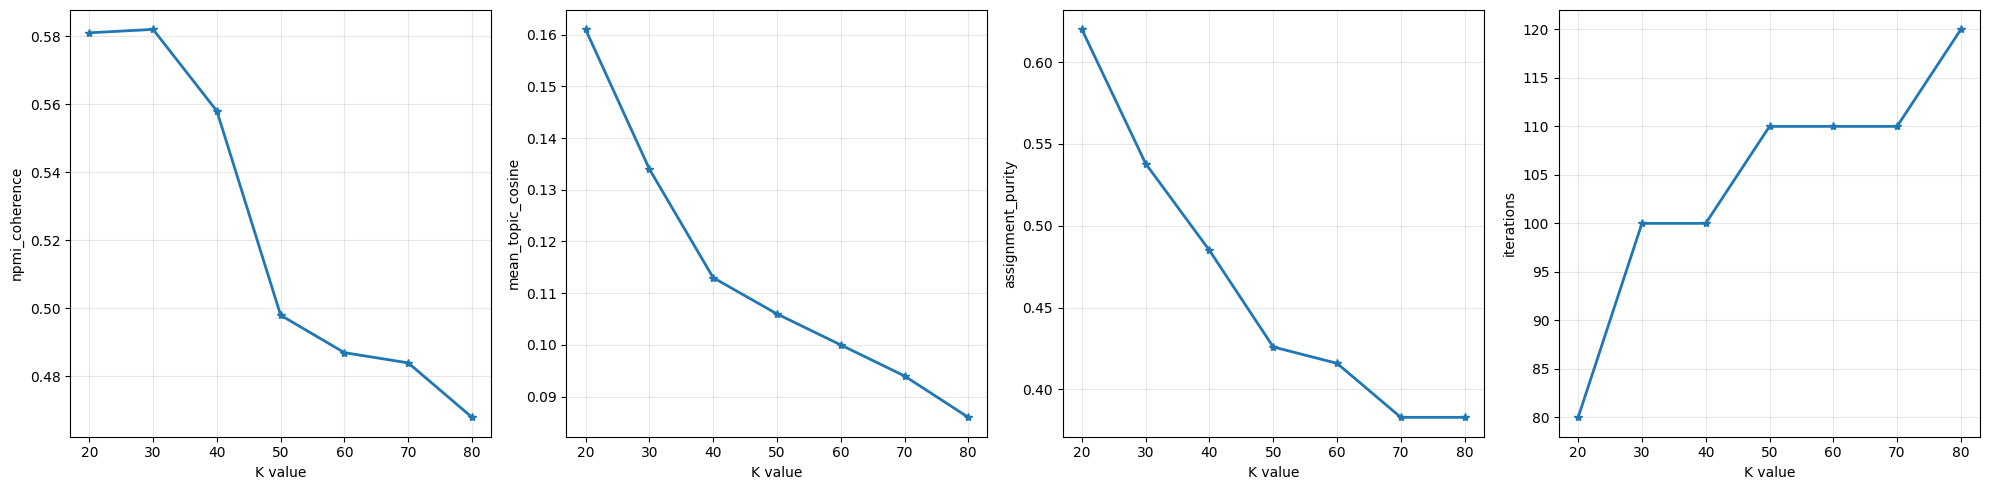

In [11]:
# K-value evaluation results
dict_k = {
    'k': [20, 30, 40, 50, 60, 70, 80],
    'npmi_coherence': [0.581, 0.582, 0.558, 0.498, 0.487, 0.484, 0.468],
    'mean_topic_cosine': [0.161, 0.134, 0.113, 0.106, 0.100, 0.094, 0.086],
    'assignment_purity': [0.620, 0.538, 0.485, 0.426, 0.416, 0.383, 0.383],
    'iterations': [80, 100, 100, 110, 110, 110, 120],
}

results_df = pd.DataFrame(dict_k)
display(results_df)

# Visualize metric trends
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['npmi_coherence', 'mean_topic_cosine', 'assignment_purity', 'iterations']

for i, metric in enumerate(metrics):
    axes[i].plot(results_df['k'], results_df[metric], marker='*', linewidth=2)
    axes[i].set_xlabel('K value')
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Conclusion**

While k=8 produces optimal metrics, 8 topics are insufficient for NRC evaluation. The data shows coherence peaks at k=20-30, but assignment purity drops sharply from 62% to 54% between k=20 and k=30. 

**Selected k values:**
- **k=20**: Best balance (coherence: 58.1%, purity: 62%)
- **k=30**: Acceptable trade-off if more granularity needed (purity: 54%)
- **k≥50**: Only for high-capacity classifiers tolerating low confidence (purity: ~43%)

The corpus supports reliable topic assignments up to k=20-30, beyond which forced subdivisions hurt interpretability.

---

### **8. Labels & Document Assignments**

**Purpose**: Create human-readable topic labels and attach per-document topic index, confidence, and label; then summarize topic prevalence.

In [12]:
# 1) Create human-readable labels from your top terms
labels_f = [make_label(ws, n=3, max_len=35) for ws in top_terms_f]
label_map = dict(enumerate(labels_f))

# P should be doc-topic probabilities for df_topics
assert P.shape[0] == len(df_topics), "P rows must match df_topics rows"

# 2) Assign topics/confidence on df_topics only
df_topics = df_topics.copy()
df_topics["nmf_topic"] = P.argmax(axis=1)
df_topics["nmf_conf"]  = P.max(axis=1)
df_topics["nmf_label"] = df_topics["nmf_topic"].map(label_map)

# 3) Merge assignments back to the full df by post_id (left join)
df = df.merge(
    df_topics[["post_id","nmf_topic","nmf_conf","nmf_label"]],
    on="post_id", how="left"
)

# 4) Topic statistics computed over the modeled subset only
TEXT_COL = "text_all"

def _tok_len(s):
    return len(ensure_tokens(s)) if isinstance(s, str) else 0

topic_stats = (df_topics
    .groupby("nmf_topic")
    .agg(
        count = ("nmf_conf","count"),
        mean  = ("nmf_conf","mean"),
        std   = ("nmf_conf","std"),
        avg_doc_length = (TEXT_COL, lambda x: np.mean([_tok_len(t) for t in x]))
    )
    .round(3)
)
topic_stats["nmf_label"] = topic_stats.index.map(label_map)

print("=== Topic Statistics (modeled subset) ===")
display(topic_stats.sort_values("count", ascending=False))

# 5) Quality check on modeled subset
low_conf_threshold = 0.40
low_conf_docs = int((df_topics["nmf_conf"] < low_conf_threshold).sum())
print(f"\nLow-confidence docs (<{low_conf_threshold}): {low_conf_docs:,} "
      f"({low_conf_docs/len(df_topics):.1%}) of modeled subset ({len(df_topics):,}).")

print(f"\nAssignment summary: {len(df_topics):,} modeled docs across {len(labels_f)} topics")
df.head(2)


=== Topic Statistics (modeled subset) ===


,count,mean,std,avg_doc_length,nmf_label
nmf_topic,,,,,
5,1108,0.670,0.175,256.187,chest pains / agoraphobia / infecti...
3,1026,0.574,0.147,453.952,she wouldn't / after her / your sis...
1,978,0.621,0.163,219.887,cultural / trains / speakers
7,897,0.624,0.177,273.118,motivation and / your progress / wi...
4,891,0.747,0.180,127.444,jobs the / liquidity / factories
6,774,0.657,0.181,199.977,training data / queries / commands
0,451,0.569,0.190,273.204,compulsion / i'm able / but often
2,158,0.774,0.209,350.532,amazing team / from mentioning / ag...



Low-confidence docs (<0.4): 612 (9.7%) of modeled subset (6,283).

Assignment summary: 6,283 modeled docs across 8 topics


,post_id,subreddit,created_ts,title,selftext,score,num_comments,upvote_ratio,over_18,removed_by_category,...,comments_concat,comment_count,text_main,text_all,comments_missing,fulltext,processed_full_text,nmf_topic,nmf_conf,nmf_label
0,1fqk5d2,HealthAnxiety,1727431124,How Do You Calm Your Mind During Health Anxiet...,I’ve been struggling with health anxiety latel...,79,63,0.98,False,<NA>,...,i try to think back on all the times i've spir...,3,how do you calm your mind during health anxiet...,how do you calm your mind during health anxiet...,0,How Do You Calm Your Mind During Health Anxiet...,"[calm, mind, dure, health, anxieti, spiral, ve...",0,0.279002,compulsion / i'm able / but often
1,1fryfai,HealthAnxiety,1727592641,Exposure therapy,Has anyone managed to overcome health anxiety ...,12,12,0.94,False,<NA>,...,starting it now! just made a fear ladder with ...,3,exposure therapy\n\nhas anyone managed to over...,exposure therapy\n\nhas anyone managed to over...,0,Exposure therapy Has anyone managed to overcom...,"[exposur, therapi, anyon, manag, overcom, heal...",5,0.800055,chest pains / agoraphobia / infecti...


---

### **9. NRC-Based Anxiety Scoring (0–1)**

**Purpose**: Load the NRC Emotion Lexicon, build a stem-aware emotion map, and compute a length-robust anxiety score per document using windowed negation and intensity cues.

In [13]:
# Load and process NRC lexicon
nrc_long = load_nrc_lexicon(NRC_PATH)

# Build stem-aware emotion mapping
ps = PorterStemmer()
nrc_long["stem"] = nrc_long["word"].apply(ps.stem)
LEX_STEM = nrc_long.groupby("stem")["emotion"].apply(set).to_dict()

# Define contextual modifiers
NEGATORS = {"not", "no", "never", "without", "hardly", "barely", "neither", "none"}
INTENSIFY = {"very", "extremely", "super", "really", "totally", "absolutely", "completely"}
DIMINISH = {"slightly", "somewhat", "kinda", "barely", "little", "bit"}

# Emotion weights for anxiety scoring
EMO_WEIGHTS = {
    "fear": 1.0, "anger": 0.8, "sadness": 0.7, "disgust": 0.4,
    "anticipation": 0.2, "surprise": 0.1, "trust": -0.4, "joy": -0.8
}

# Apply anxiety scoring to corpus
df["anxiety_score"] = df["processed_full_text"].apply(compute_anxiety_score)

print(f"Anxiety scores: {df['anxiety_score'].min():.3f} to {df['anxiety_score'].max():.3f}")
df[["nmf_topic", "nmf_label", "anxiety_score"]].head()

Loaded NRC lexicon: 13872 word-emotion pairs
Anxiety scores: -2.524 to 11.350


,nmf_topic,nmf_label,anxiety_score
0,0,compulsion / i'm able / but often,1.549193
1,5,chest pains / agoraphobia / infecti...,0.536656
2,5,chest pains / agoraphobia / infecti...,4.039837
3,0,compulsion / i'm able / but often,4.853627
4,7,motivation and / your progress / wi...,1.192327


---

### **10. Save Artifacts for Reuse**

**Purpose**: Persist the trained vectorizer, NMF model, topic labels, and annotated dataset to disk for downstream analysis and reproducible pipelines.

In [14]:
# Save vectorizer and NMF model
joblib.dump(vec_final, "../artifacts/vec_final.joblib")
joblib.dump(nmf_final, "../artifacts/nmf_final.joblib")

# Save topic labels
with open("../artifacts/topic_labels.json", "w") as f:
    json.dump(labels_f, f, indent=2)

# Save annotated dataframe (topics + anxiety scores if present)
df.to_csv("../artifacts/posts_with_topics_and_anxiety.csv", index=False)

print("Saved artifacts: vec_final.joblib, nmf_final.joblib, topic_labels.json, posts_with_topics_and_anxiety.csv")

Saved artifacts: vec_final.joblib, nmf_final.joblib, topic_labels.json, posts_with_topics_and_anxiety.csv


---

### **11. Word Cloud Visualization**
**Purpose**: Create visual word clouds to explore vocabulary patterns across all text, anxiety levels, and topics.


In [15]:
# Verify required columns exist
LABEL_COL = "topic_label" if "topic_label" in df.columns else "nmf_label"
if LABEL_COL not in df.columns or "anxiety_score" not in df.columns:
    raise RuntimeError("Missing required columns. Run previous sections first.")

# Topic-level anxiety analysis
print("=== Topic Anxiety Analysis ===")
topic_anxiety = (
    df.groupby(["nmf_topic", LABEL_COL])["anxiety_score"]
    .agg(['count', 'mean', 'std'])
    .round(3)
    .reset_index()
)

print("Highest anxiety topics:")
display(topic_anxiety.sort_values('mean', ascending=False).head(5))
print("Lowest anxiety topics:")
display(topic_anxiety.sort_values('mean', ascending=True).head(5))

=== Topic Anxiety Analysis ===
Highest anxiety topics:


,nmf_topic,nmf_label,count,mean,std
5,5,chest pains / agoraphobia / infecti...,1108,3.100,1.870
0,0,compulsion / i'm able / but often,451,2.466,1.760
3,3,she wouldn't / after her / your sis...,1026,2.429,1.949
2,2,amazing team / from mentioning / ag...,158,2.109,1.964
7,7,motivation and / your progress / wi...,897,1.181,1.611


Lowest anxiety topics:


,nmf_topic,nmf_label,count,mean,std
6,6,training data / queries / commands,774,0.629,1.296
4,4,jobs the / liquidity / factories,891,0.922,1.325
1,1,cultural / trains / speakers,978,1.068,1.496
7,7,motivation and / your progress / wi...,897,1.181,1.611
2,2,amazing team / from mentioning / ag...,158,2.109,1.964


Creating word cloud for all processed text...


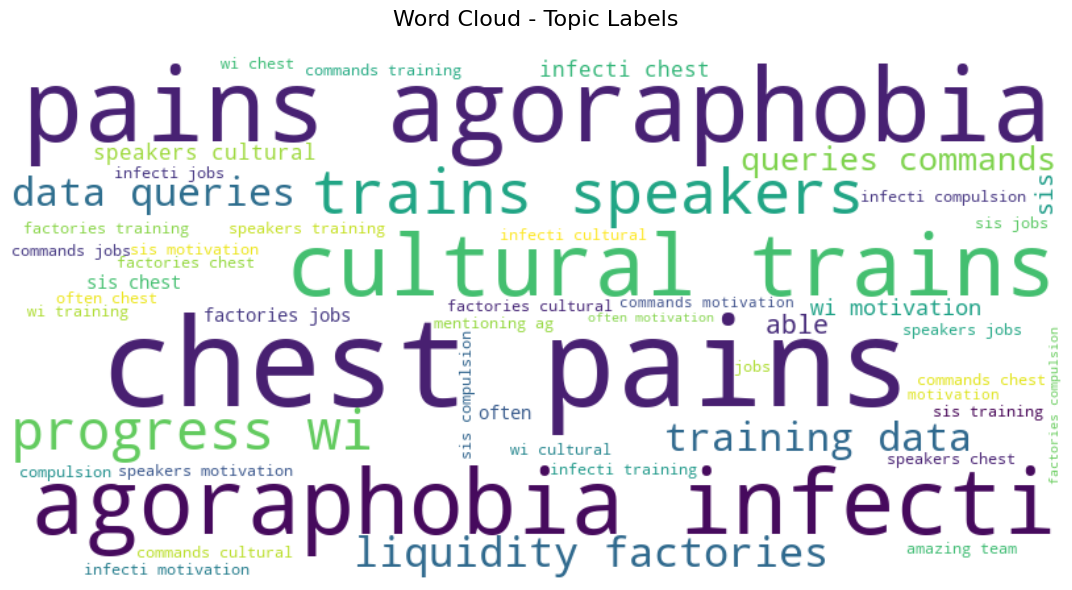

In [16]:
# Word Cloud Visualization for topic labels

print("Creating word cloud for all processed text...")

# --- Using topic labels ---
wordcloud_all = create_word_cloud(
    df[LABEL_COL].dropna(), 
    title="Word Cloud - Topic Labels",
    max_words=50
)

High anxiety documents: 1,571
Low anxiety documents: 1,571


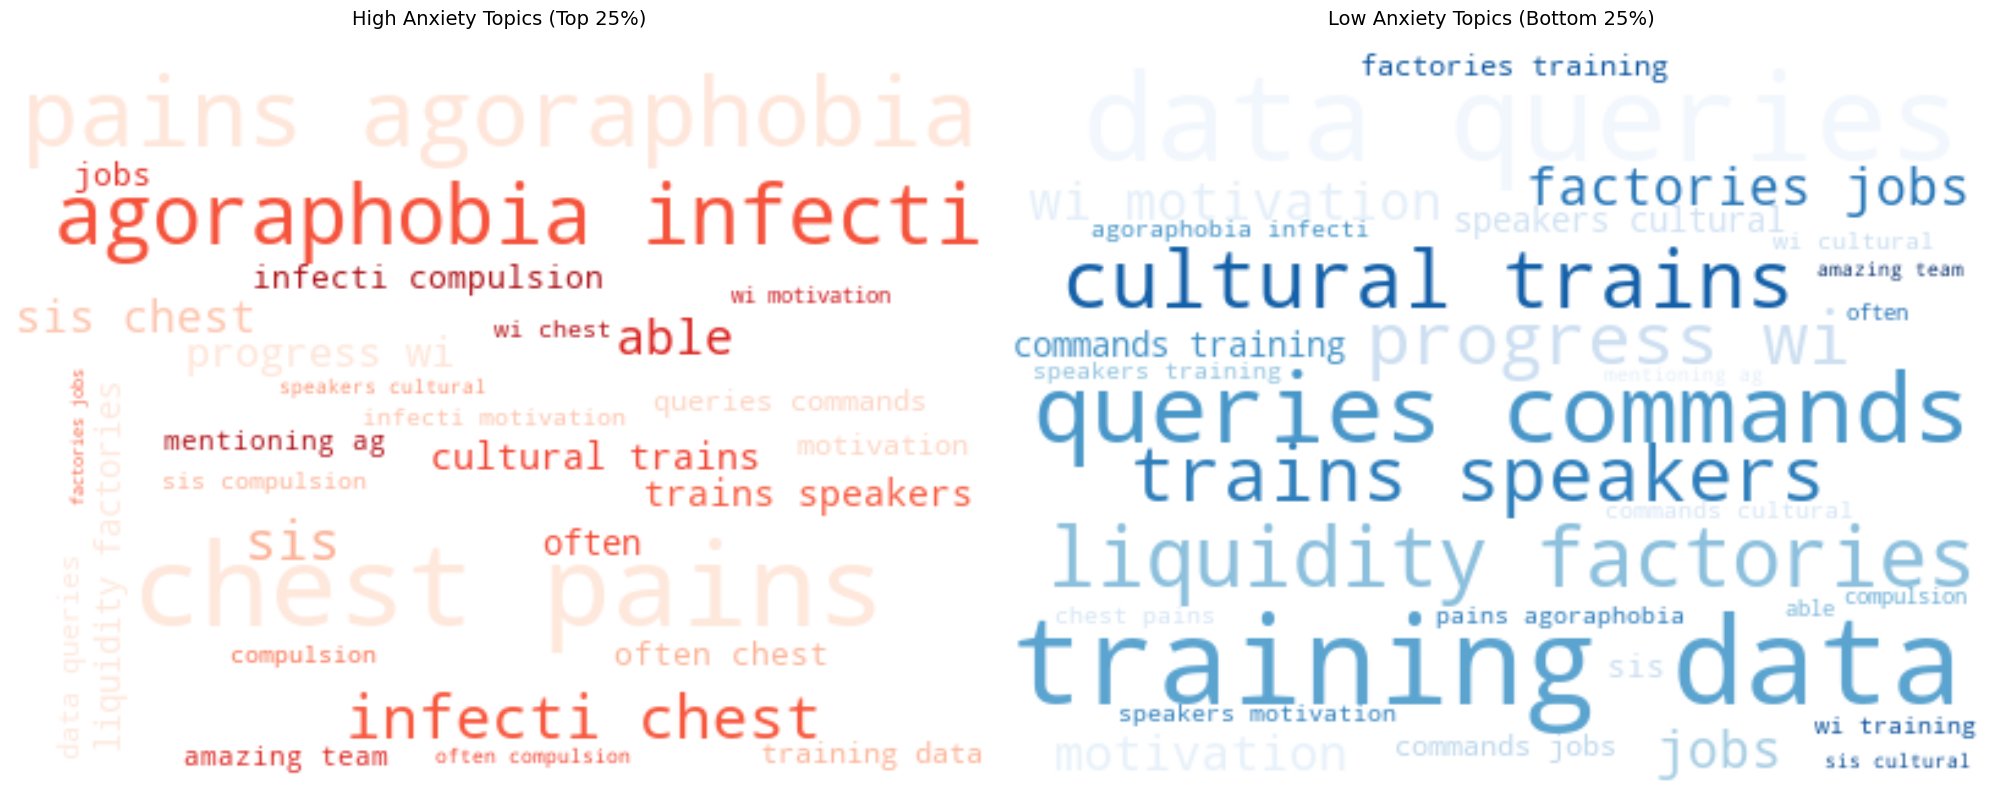

In [17]:
# Word cloud comparison: high vs low anxiety topic labels
if "anxiety_score" in df.columns:
    # High anxiety posts (top 25%)
    high_anxiety_threshold = df["anxiety_score"].quantile(0.75)
    high_labels = label_to_tokens(df.loc[df["anxiety_score"] >= high_anxiety_threshold, LABEL_COL])
    
    # Low anxiety posts (bottom 25%)
    low_anxiety_threshold = df["anxiety_score"].quantile(0.25)
    low_labels = label_to_tokens(df.loc[df["anxiety_score"] <= low_anxiety_threshold, LABEL_COL])

    print(f"High anxiety documents: {len(high_labels):,}")
    print(f"Low anxiety documents: {len(low_labels):,}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    if len(high_labels) > 0:
        high_text = " ".join(token for tokens in high_labels for token in tokens)
        wordcloud_high = WordCloud(
            width=400, height=300, background_color="white",
            max_words=100, colormap="Reds", relative_scaling=0.5,
            random_state=42
        ).generate(high_text)

        ax1.imshow(wordcloud_high, interpolation="bilinear")
        ax1.set_title("High Anxiety Topics (Top 25%)", fontsize=14, pad=20)
        ax1.axis("off")

    if len(low_labels) > 0:
        low_text = " ".join(token for tokens in low_labels for token in tokens)
        wordcloud_low = WordCloud(
            width=400, height=300, background_color="white",
            max_words=100, colormap="Blues", relative_scaling=0.5,
            random_state=42
        ).generate(low_text)

        ax2.imshow(wordcloud_low, interpolation="bilinear")
        ax2.set_title("Low Anxiety Topics (Bottom 25%)", fontsize=14, pad=20)
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

---

### **12. NRC VAD Lexicon Exploration**

**Purpose**: Compare topic-level anxiety patterns using the NRC VAD Lexicon as an alternative to the emotion-based approach, applying dimensional affect theory to validate our anxiety measurements.

**Background**: The NRC VAD Lexicon provides continuous ratings for Valence (pleasant ↔ unpleasant), Arousal (calm ↔ excited), and Dominance (controlled ↔ submissive) based on Mehrabian & Russell's PAD framework (1974). Research suggests anxiety corresponds to low valence, high arousal, and low dominance (Russell, 1980; Bradley & Lang, 1994).

**Method**: We use a simple unweighted combination where anxiety-related content has low valence, high arousal, and low dominance: `anxiety_vad = (1-valence) + arousal + (1-dominance)`, then normalize to [0,1] scale.

In [18]:
# Load NRC VAD Lexicon
VAD_PATH = Path("../data/raw/NRC_EmoLex_NRC-VAD-Lexicon.txt")

# Parse VAD file
vad_data = []
with VAD_PATH.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        parts = line.split('\t')
        if len(parts) == 4:
            vad_data.append(parts)

vad_df = pd.DataFrame(vad_data, columns=["word", "valence", "arousal", "dominance"])

# Clean and process
vad_df = vad_df.assign(
    word=lambda x: x["word"].str.lower().str.strip(),
    valence=lambda x: pd.to_numeric(x["valence"], errors="coerce"),
    arousal=lambda x: pd.to_numeric(x["arousal"], errors="coerce"), 
    dominance=lambda x: pd.to_numeric(x["dominance"], errors="coerce")
).dropna().drop_duplicates("word")

# Create stem lookup
vad_df["stem"] = vad_df["word"].apply(ps.stem)
vad_stem = vad_df.groupby("stem")[["valence", "arousal", "dominance"]].mean()

print(f"VAD lexicon: {len(vad_df):,} words → {len(vad_stem):,} stems")

def compute_vad_anxiety(tokens):
    """Compute VAD anxiety score for document tokens."""
    if not isinstance(tokens, list):
        tokens = ensure_tokens(tokens)
    
    vad_scores = []
    for token in tokens:
        stem = ps.stem(token.lower())
        if stem in vad_stem.index:
            vad_scores.append(vad_stem.loc[stem])
    
    if not vad_scores:
        return 0.0
    
    # Average VAD values across found tokens
    avg_vad = pd.concat(vad_scores, axis=1).mean(axis=1)
    
    # Anxiety formula: low valence + high arousal + low dominance
    anxiety_raw = (1 - avg_vad["valence"]) + avg_vad["arousal"] + (1 - avg_vad["dominance"])
    
    # Normalize to [0,1] scale (theoretical max is 3.0)
    return float(min(anxiety_raw / 3.0, 1.0))

# Apply VAD scoring to document text
print("Computing VAD anxiety scores...")
df["anxiety_vad"] = df["processed_full_text"].apply(compute_vad_anxiety)

# Compare methods at topic level
topic_comparison = df.groupby(["nmf_topic", "nmf_label"]).agg({
    "anxiety_score": "mean",
    "anxiety_vad": "mean"
}).round(3).reset_index()

topic_comparison["anxiety_diff"] = abs(topic_comparison["anxiety_score"] - topic_comparison["anxiety_vad"])

print("\n=== VAD vs Emotion Lexicon Comparison ===")
print("Topics with largest differences:")
display(topic_comparison.sort_values("anxiety_diff", ascending=False))

print("\nCorrelation between methods:")
correlation = df[["anxiety_score", "anxiety_vad"]].corr().iloc[0,1]
print(f"Pearson correlation: {correlation:.3f}")

print(f"\nVAD anxiety range: {df['anxiety_vad'].min():.3f} to {df['anxiety_vad'].max():.3f}")

VAD lexicon: 19,971 words → 15,390 stems
Computing VAD anxiety scores...

=== VAD vs Emotion Lexicon Comparison ===
Topics with largest differences:


,nmf_topic,nmf_label,anxiety_score,anxiety_vad,anxiety_diff
5,5,chest pains / agoraphobia / infecti...,3.100,0.476,2.624
0,0,compulsion / i'm able / but often,2.466,0.454,2.012
3,3,she wouldn't / after her / your sis...,2.429,0.448,1.981
2,2,amazing team / from mentioning / ag...,2.109,0.451,1.658
7,7,motivation and / your progress / wi...,1.181,0.432,0.749
1,1,cultural / trains / speakers,1.068,0.441,0.627
4,4,jobs the / liquidity / factories,0.922,0.444,0.478
6,6,training data / queries / commands,0.629,0.433,0.196



Correlation between methods:
Pearson correlation: 0.556

VAD anxiety range: 0.000 to 0.741


**Conclusion**

The NRC Emotion and VAD lexicons show moderate correlation (r = 0.515), indicating they capture related but distinct anxiety dimensions. The VAD method produces compressed scores (0.000-0.792) compared to emotion scores (0.7-3.1), with largest disagreements on medical and social separation topics.

The emotion lexicon appears more sensitive to explicit anxiety language, while VAD captures subtler affective patterns. These substantial differences suggest complementary rather than competing approaches. Without external validation criteria, we cannot determine which method is more accurate.

**Recommendation:** Both lexicons offer valuable perspectives on anxiety measurement. Future work should focus on external validation and potentially combining both approaches for more robust assessment.

---

### **Reference(s)**
- Mehrabian, A., & Russell, J. A. (1974). An Approach to Environmental Psychology.
